In [71]:
import pandas as pd
import numpy as np
from collections import Counter
#nltk
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

#Utiity
import re

tqdm.pandas()

import matplotlib.pyplot as plt

plt.style.use('default')

In [57]:
tweet_df = pd.read_csv('./preprocessing/kaggle_dataset/text_emotion.csv')
data = pd.read_csv('./preprocessing/kaggle_dataset/Emotion_final.csv')

<AxesSubplot:>

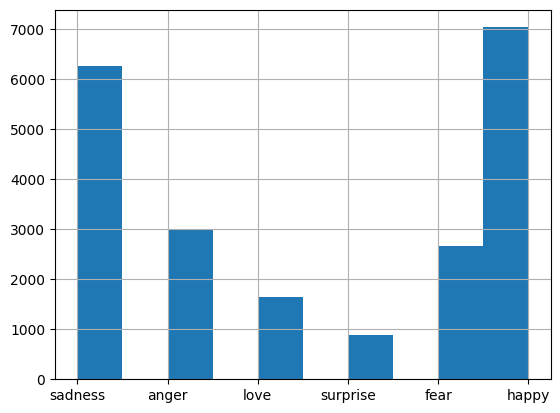

In [72]:
data['Emotion'].hist()

In [5]:
tweet_df = tweet_df[['content','sentiment']]

In [6]:
tweet_df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [7]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = stopwords.words("english")
n=WordNetLemmatizer()

def _preprocess(sentence):
    # Remove link,user and special characters
    sentence = re.sub(TEXT_CLEANING_RE, ' ', str(sentence).lower()).strip()
    sentence = word_tokenize(sentence)
    sentence = [w for w in sentence if not w in stop_words]  # Remove stopwords.
    return " ".join(sentence)

def _lemmatize(tokens):
    """단어 리스트를 받아 품사를 구분하여 원형으로 바꿔줍니다."""
    textTags = nltk.pos_tag(tokens)
    result = list()
    n=WordNetLemmatizer()
    for word , tag in textTags:
        if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP']:
            result.append(n.lemmatize(word,'v'))
        else:
            result.append(n.lemmatize(word))
    return result

# nltk.pos
def get_pos_tags(corpus):
    temp = []
    tokens = word_tokenize(corpus)
    tokens = _lemmatize(tokens)
    for word,tag in nltk.pos_tag(tokens):
        if tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:
            temp.append(word)
        elif tag in ['NN','NNP','NNS','NNPS']:
            temp.append(word)
        elif tag in ['JJ','JJR','JJS','RB','RBR','RBS']:
            temp.append(word)
    return temp

In [8]:
tweet_df['sentiment'] = tweet_df['sentiment'].map({'surprise' : 1,
                                                   'love' : 2,
                                                   'happiness' : 3,
                                                   'sadness' : 4,
                                                   'anger':5,
                                                   'hate':5,
                                                   'empty' :6 })
tweet_df = tweet_df.dropna(axis=0)

In [9]:
tweet_df['content'] = tweet_df['content'].progress_map(_preprocess)

100%|█████████████████████████████████████████████████████████████████████████| 18663/18663 [00:01<00:00, 12441.99it/s]


In [10]:
# 글자 수 적은거 제거
tweet_df['content'] = tweet_df['content'].map(lambda x : x if len(x) > 15 else np.nan)
tweet_df = tweet_df.dropna(axis=0)

In [11]:
tweet_df.rename(columns={'content' : 'Text' , 'sentiment' : 'Emotion' }, inplace = True)

In [12]:
tweet_df['Emotion'].value_counts().sort_index()

1.0    1889
2.0    3454
3.0    4708
4.0    4578
5.0    1295
6.0     641
Name: Emotion, dtype: int64

In [13]:
sp_tw = tweet_df[tweet_df['Emotion'] == 1].sample(n=2000 , random_state=2021,replace=True)
lv_tw = tweet_df[tweet_df['Emotion'] == 2].sample(n=3000 , random_state=2021,replace=True)
hp_tw = tweet_df[tweet_df['Emotion'] == 3].sample(n=3000 , random_state=2021,replace=True)
sd_tw = tweet_df[tweet_df['Emotion'] == 4].sample(n=3000 , random_state=2021,replace=True)
ag_tw = tweet_df[tweet_df['Emotion'] == 5].sample(n=2000 , random_state=2021,replace=True)
fe_tw = tweet_df[tweet_df['Emotion'] == 6].sample(n=1000 , random_state=2021,replace=True)

In [14]:
data['Emotion'] = data['Emotion'].map({'surprise':1,
                                      'love' : 2,
                                      'happy' :3,
                                      'sadness': 4,
                                      'anger': 5,
                                      'fear':6})

In [15]:
data['Emotion'].value_counts().sort_index()

1     879
2    1641
3    7029
4    6265
5    2993
6    2652
Name: Emotion, dtype: int64

In [16]:
sp_df = data[data['Emotion'] == 1].sample(n=1000 , random_state=2021,replace=True)
lv_df = data[data['Emotion'] == 2].sample(n=2000 , random_state=2021,replace=True)
hp_df = data[data['Emotion'] == 3].sample(n=3000 , random_state=2021,replace=True)
sd_df = data[data['Emotion'] == 4].sample(n=3000 , random_state=2021,replace=True)
ag_df = data[data['Emotion'] == 5].sample(n=3000 , random_state=2021,replace=True)
fe_df = data[data['Emotion'] == 6].sample(n=3000 , random_state=2021,replace=True)

In [17]:
df_full = pd.concat([sp_df,sp_tw,lv_df,lv_tw,hp_df,hp_tw,sd_tw,sd_df,ag_df,ag_tw,fe_tw,fe_df],axis=0)

<AxesSubplot:>

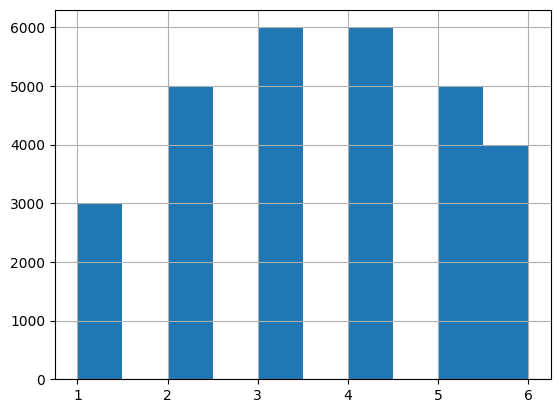

In [73]:
df_full['Emotion'].hist()

In [69]:
df_full.to_csv('emotion_normal.csv',index=False)

In [20]:
emotion = {'surprise' : '' , 'love' : '' , 'happy' : '' , 'sadness' : '' , 'anger': '' , 'fear': ''}

In [21]:
for i in range(len(emotion)):
    emotion_df = df_full[df_full['Emotion'] == i+1]
    corpus = " ".join(emotion_df['Text'].values)
    corpus = _preprocess(corpus)
    emotion[list(emotion.keys())[i]] = corpus

In [22]:
emotion_count = {}
vocab = {}
for i in range(len(emotion)):
    emotion_key = list(emotion.keys())[i]
    emotion_count[emotion_key] = Counter(get_pos_tags(emotion[emotion_key])).most_common(2000)
    for words , counts in emotion_count[emotion_key]:
        if words in list(vocab.keys()):
            vocab[words][emotion_key] = counts
        else:
            vocab[words] = { emotion_key : counts }

In [58]:
emotion_keys = list(emotion.keys())
for word in list(vocab.keys()):
    total = sum(vocab[word].values())
    for keys in emotion_keys:
        try:
            vocab[word][keys] = round( (vocab[word][keys]  / total) , 2 )
        except KeyError:
            pass

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def emotion_show_wordcloud(emotion_name):
    wc = WordCloud(background_color='white', width=800, height=600)
    cloud = wc.generate_from_frequencies(dict(emotion_count[emotion_name]))
    plt.figure(figsize=(10,8))
    plt.axis('off')
    plt.imshow(cloud)

In [30]:
test = data.sample(10)
test

,Text,Emotion
7538,i like you and im feeling generous,3
13338,i am empowered i feel superior,3
4185,i feel pretty fantastic,3
15576,i feel my desire to learn or explore the truth...,3
2862,i was angry and feeling so disillusioned,4
9103,i feel about oprah she is such a draw to women...,3
11903,i may feel that way but the fact that stories ...,3
10907,i would feel disheartened so i would then go a...,4
2975,i remember sitting in class actually feeling e...,3
14899,i still have feelings after we broke up,4


In [31]:
test['Text'].values[1]

'i am empowered i feel superior'

In [50]:
def lexicon_emotion_clf(sentence):
    temp = Counter()
    for word in get_pos_tags(sentence):
        try:
            temp = temp + Counter(vocab[word])
        except KeyError:
            pass
    emotion = list(temp.keys())
    score = list(temp.values())
    
    print(temp)
    
    plt.pie(score, labels=emotion, autopct='%.1f%%')
    plt.show()
    
    return [k for k,v in dict(temp).items() if max(dict(temp).values()) == v]

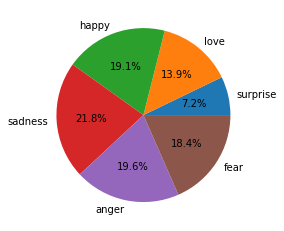

['sadness']
['i', 'im', 'feeling', 'generous']


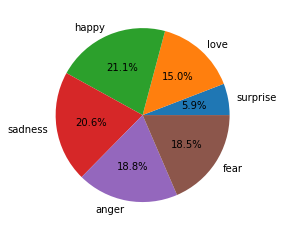

['happy']
['i', 'be', 'empower', 'i', 'feel', 'superior']


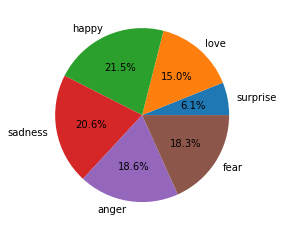

['happy']
['i', 'feel', 'pretty', 'fantastic']


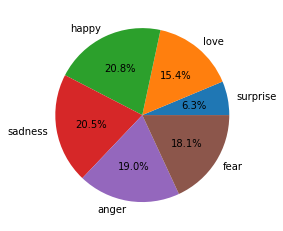

['happy']
['i', 'feel', 'desire', 'learn', 'explore', 'truth', 'say', 'spirituality', 'lead', 'useful', 'source']


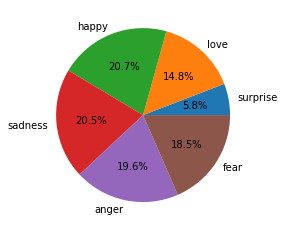

['happy']
['i', 'be', 'angry', 'feel', 'so', 'disillusioned']


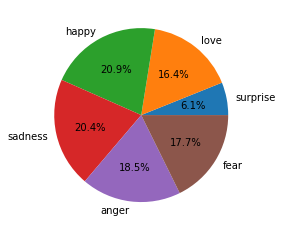

['happy']
['i', 'feel', 'oprah', 'is', 'such', 'draw', 'woman', 'is', 'friendly', 'ha', 'dealt', 'struggle', 'openly', 'weight', 'abuse', 'seems', 'genuinely', 'care', 'issue', 'concern', 'life']


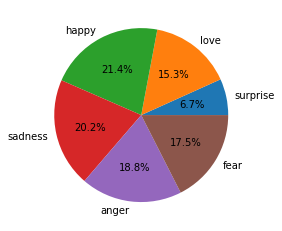

['happy']
['i', 'feel', 'way', 'fact', 'story', 'create', 'adult', 'be', 'mean', 'child', 'contain', 'message', 'be', 'not', 'so', 'innocent', 'really', 'make', 'wonder', 'exactly', 'is', 'more', 'mature']


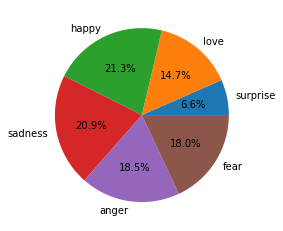

['happy']
['i', 'feel', 'dishearten', 'i', 'then', 'go', 'do', 'cardio', 'hour', 'achieve', 'calorie']


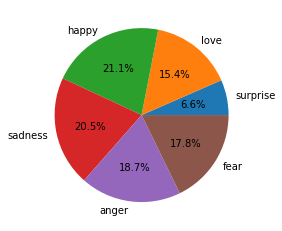

['happy']
['i', 'remember', 'sit', 'class', 'actually', 'feel', 'eager', 'learn', 'amp', 'p']


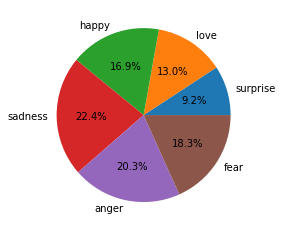

['sadness']
['i', 'still', 'have', 'feeling', 'break']


In [36]:
for i in test['Text']:
    print(lexicon_emotion_clf(i))
    print(get_pos_tags(i))

In [60]:
np.save('emotion_vocab(en).npy', vocab)

In [60]:
pd.DataFrame(vocab).T.to_excel('vocab.xlsx')

Counter({'love': 0.6, 'happy': 0.16, 'surprise': 0.07, 'sadness': 0.07, 'anger': 0.06, 'fear': 0.05})


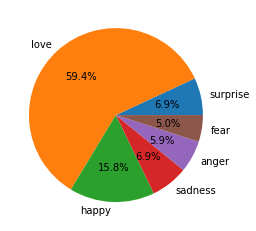

['love']

In [62]:
lexicon_emotion_clf('love')

In [82]:
tweet_df['content'][0]

'@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =['

In [83]:
get_pos_tags(tweet_df['content'][0])

['tiffanylue',
 'i',
 'know',
 'i',
 'be',
 'listenin',
 'bad',
 'habit',
 'earlier',
 'i',
 'start',
 'freakin',
 'part',
 '=',
 '[']